In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
epochs = 10         # エポック数
batch = 123         # ミニバッチサイズ
learning_rate = 0.001   # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data',train = True,download = True,transform = transform)
test_dataset = datasets.MNIST('./data',train = False,transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = batch,shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = batch,shuffle = True)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model.train()  # モデルを訓練モードにする
loss_rec = []
for epoch in range(epochs): # 学習を繰り返し行う
    loss_sum = 0
    for batch_inputs, (inputs, labels) in enumerate(train_dataloader): #<<修正箇所>>
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.view(inputs.size(0), -1) #<<修正箇所>>
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_sum += loss
        loss.backward()
        optimizer.step()
    loss_rec.append((loss_sum/len(train_dataloader)).to('cpu').detach().clone().numpy()) #<<修正箇所>>
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss_sum / len(train_dataloader)}")

Epoch: 1/10, Loss: 0.7090701460838318
Epoch: 2/10, Loss: 0.2822783291339874
Epoch: 3/10, Loss: 0.2227620780467987
Epoch: 4/10, Loss: 0.1868620365858078
Epoch: 5/10, Loss: 0.16131383180618286
Epoch: 6/10, Loss: 0.1408342868089676
Epoch: 7/10, Loss: 0.12478671222925186
Epoch: 8/10, Loss: 0.11120092123746872
Epoch: 9/10, Loss: 0.09995989501476288
Epoch: 10/10, Loss: 0.09003132581710815


Loss: 0.04773544974443389, Accuracy: 81.18% (8118/10000)


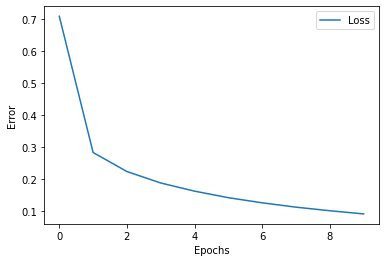

In [ ]:
model.eval()  # モデルを評価モードにする
loss_sum = 0
correct = 0
with torch.no_grad():
    for batch_inputs in test_dataloader:
        inputs = inputs.to(device) #<<修正箇所>>
        labels = labels.to(device) #<<修正箇所>>
        inputs = inputs.view(inputs.size(0),-1) #<<修正箇所>>
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels)
        pred = outputs.argmax(1)
        correct += pred.eq(labels.view_as(pred)).sum().item()
print(f"Loss: {loss_sum.item() / len(test_dataloader)}, Accuracy: {100*correct/len(test_dataset)}% ({correct}/{len(test_dataset)})")
plt.plot(range(len(loss_rec)), loss_rec, label="Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

**修正場所1**

修正前

```
for batch_inputs in train_dataloader:

```

修正後
```
for batch_inputs, (inputs, labels) in enumerate(train_dataloader):

```

理由

修正前ではinput,labelが定義されておらずエラーが出力されてしまうため、enumerateを使用してinputs,labelsに分割しさらにイテレーション毎にインデックス付きの要素を返している。


**修正場所2**

修正前

```
inputs = inputs.view(batch, -1)

```


修正後

```
inputs = inputs.view(inputs.size(0), -1)
```

理由

modelにより計算する際に形をそろえるため、inputのtensorの0番目の大きさを取得する。通常はバッチサイズと同じ値になるため、問題がないが今回の例ではデータセット内のすべてのサンプルを指定されたバッチサイズに分割することを前提としているため、ずれが生じてしまう。そのためそれ防ぐために行った。

**修正場所3**

修正前

```
loss_rec.append(loss_sum/len(train_dataloader)) 

```


修正後

```
loss_rec.append((loss_sum/len(train_dataloader)).to('cpu').detach().clone().numpy())

```

理由

tensor型をnumpy形式に変換することでmatplotlibでグラフ表示できるようにした。



**修正場所4**

修正前

```
inputs = batch_inputs.inputs.to(device) 
labels = batch_inputs.label.to(device) 

```


修正後


```
inputs = inputs.to(device) 
labels = labels.to(device)
```

理由

inputs,labelsをGPUに取り込むため。

**修正場所4**

修正前

```
inputs = inputs.view(-1)

```


修正後


```
inputs = inputs.view(inputs.size(0),-1)
```

理由

先ほどと同様
